
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [3]:
#Dropout: 0, 10%
DROPOUT = 0

#Learning rate: 2.5e-5 e 5e-5
LEARNING_RATE = 2.5e-5

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModel.from_pretrained("xlm-roberta-large")

In [5]:
df = pd.read_csv('../datasets/buscape_preprocessed.csv')

In [6]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [7]:
print(f'{df.shape[0]} instancias, {df.shape[1]} classes')

133632 instancias, 2 classes


#### Dividindo dataset em dois batchs, 50% cada

In [8]:
reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [9]:
print(f'batch_01: {reviews_batch_01.shape[0]} instancias')
print(f'batch_02: {reviews_batch_02.shape[0]} instancias')

batch_01: 66816 instancias
batch_02: 66816 instancias


#### Quantidade de avaliações positivas e negativas no batch_01

In [10]:
labels_batch_01.value_counts()

rating
1    33477
0    33339
Name: count, dtype: int64

In [11]:
reviews = reviews_batch_01
labels = labels_batch_01

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [ ]:
embeddings = []
for review in tqdm((reviews), desc='Processing'):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing:  43%|████▎     | 29023/66816 [4:04:27<4:38:33,  2.26it/s] 

In [24]:
embeddings_array = np.vstack(embeddings)

In [25]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

6810 embeddings de 1024 dimensões


#### Feature based 1

In [26]:
additional_features = np.array([[len(review.split())] for review in reviews_batch_02])

In [27]:
print(embeddings_array.shape)
print(additional_features.shape)

(6810, 1024)
(6810, 1)


#### Combinando embeddings_array e additional_features

In [28]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [29]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [30]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [31]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [32]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                24624     
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 24,649
Trainable params: 24,649
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [34]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#### Treinamento do modelo

fold = 1
Epoch 1/10
192/192 [==============================] - 1s 2ms/step - loss: 0.7231 - accuracy: 0.6128
Epoch 2/10
192/192 [==============================] - 0s 1ms/step - loss: 0.5789 - accuracy: 0.7130
Epoch 3/10
192/192 [==============================] - 0s 1ms/step - loss: 0.5160 - accuracy: 0.7510
Epoch 4/10
192/192 [==============================] - 0s 1ms/step - loss: 0.4756 - accuracy: 0.7858
Epoch 5/10
192/192 [==============================] - 0s 1ms/step - loss: 0.4419 - accuracy: 0.8088
Epoch 6/10
192/192 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.8124
Epoch 7/10
192/192 [==============================] - 0s 1ms/step - loss: 0.4057 - accuracy: 0.8246
Epoch 8/10
192/192 [==============================] - 0s 1ms/step - loss: 0.3953 - accuracy: 0.8326
Epoch 9/10
192/192 [==============================] - 0s 1ms/step - loss: 0.3835 - accuracy: 0.8349
Epoch 10/10
22/22 [==============================] - 0s 926us/step
fold = 2
Epoch 1/10
192/

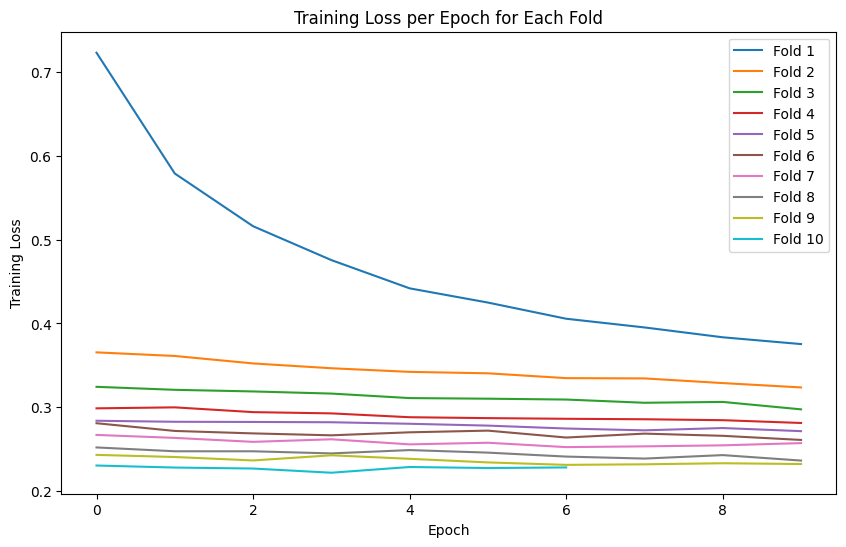

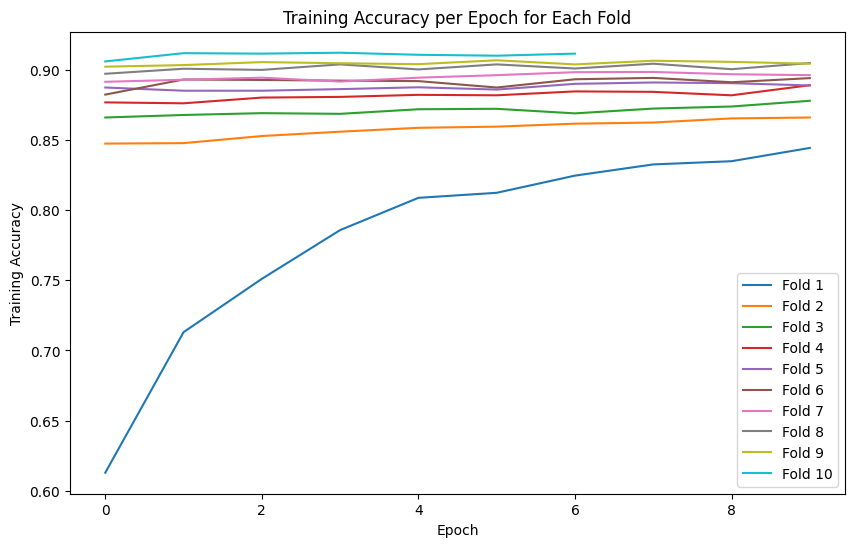

In [35]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in kf.split(combined_features):
    fold+=1
    print(f'fold = {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=1,
        callbacks=[EarlyStopping('loss', patience=3)],
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print("Cross-Validation Accuracies:", fold_accuracies)
print("Cross-Validation Scores:", fold_f1_scores)
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()

In [36]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

43/43 [==============================] - 0s 946us/step - loss: 0.1831 - accuracy: 0.9280
